# Problem 1 
  
  #### I Load the data in and take the stft. I then remove any columns of the spectrogram where the sum of the magnitude of its bins is less than 20000 based on what i observed. This gets rid of parts of audio where its silent that can mess with our clustering

(1025, 1168) <---Initial spec
(1025, 1140) <--Removed Low Energy columns


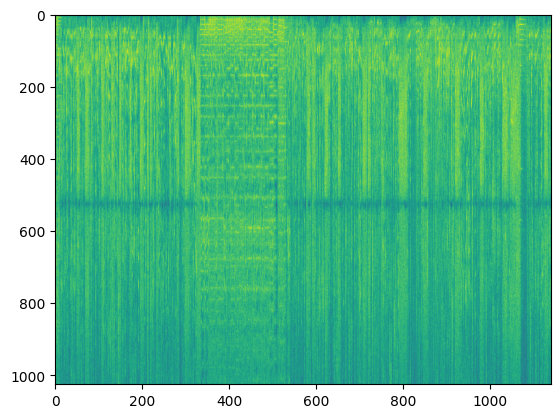

In [77]:
from scipy.io import wavfile
from scipy.signal import stft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from sklearn.mixture import GaussianMixture
from hmmlearn import hmm


np.random.seed(0)

file_path = 'friends.wav'
sr, audio_data = wavfile.read(file_path)

summedPowerThreshold = 20000
n_fft = 2048
overlap = 0
f, t, Zxx = stft(audio_data, fs=sr, nperseg=n_fft, noverlap=overlap)
summedPower = np.sum(np.abs(Zxx),axis=0) #incase i need later
filteredforPower = Zxx[:, summedPower > summedPowerThreshold]
log_spec = 10 * np.log10(np.abs(filteredforPower))
plt.imshow(log_spec, aspect='auto')

print(Zxx.shape,"<---Initial spec")
print(log_spec.shape, "<--Removed Low Energy columns")


### Get labels for entire spectrogram then remove labels for the relatively silent bins that were in the spectrogram

Text(0.5, 1.0, 'Ground Truth')

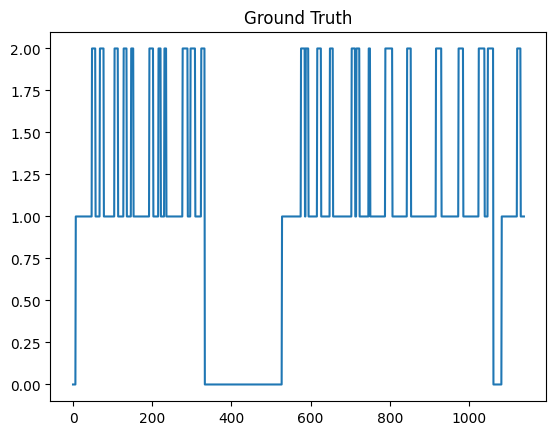

In [78]:
## Getting labels

labels_file_path = 'friendsLabels.txt'
with open(labels_file_path, 'r') as file:
    labels_data = file.readlines()

N = Zxx.shape[1]
MaxTime = 298.711700
fullLabels = np.full(N, -2, dtype=int)

for line in labels_data:
    start_time, end_time, label = line.strip().split('\t')
    start_idx = int(float(start_time)/298.711700 * N)
    end_idx =  int(float(end_time)/298.711700 * N) 
    if label == 'music':
        fullLabels[start_idx:end_idx] = 0
    elif label == 'speech':
        fullLabels[start_idx:end_idx] = 1
    elif label == 'laughter':
        fullLabels[start_idx:end_idx] = 2

groundTruthLabels = fullLabels[summedPower > summedPowerThreshold]
plt.plot(groundTruthLabels)
plt.title('Ground Truth')


In [79]:
def pca(data): #takes input data as columns and expects it to be 0 mean (add mean back later if intended)
    covariance_matrix = np.dot(data,data.T)/(data.shape[1])
    eigvals, eigvecs = np.linalg.eigh(covariance_matrix)
    eigvals = eigvals[::-1]
    eigvecs = eigvecs[:,::-1]

    return (eigvecs,eigvals)

def pcaReduce(data,n_components): #return eigvals and reduced data, and mean it subtracted 
    mean = np.mean(data,axis=1).reshape(-1,1)
    vecs, vals = pca(data - mean)
    reduced = vecs.T[:n_components] @ (data - mean)
    return reduced,vals,mean



In [80]:
dataP1,eigvalsP1, meanP1 = pcaReduce(log_spec,4) #get reduced data



### Kmean

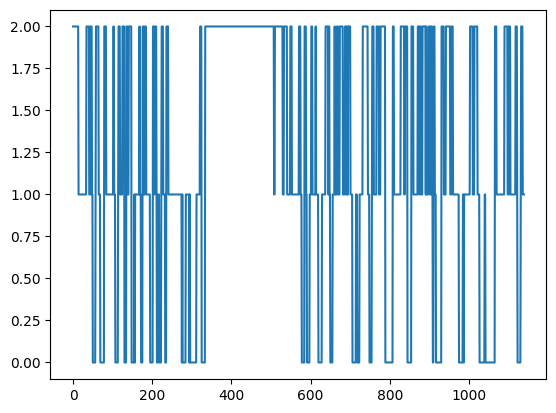

In [81]:


n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, n_init=1)
kmeans.fit(dataP1.T)

# Get cluster labels and centroids
labels_knn = kmeans.labels_
centroids = kmeans.cluster_centers_

filtered_labels_knn = median_filter(labels_knn, size=4, mode='reflect')

plt.plot(filtered_labels_knn)

### GMM 

In [82]:

gmm = GaussianMixture(n_components=n_clusters,n_init=1)
gmm.fit(dataP1.T)


labels_gmm = gmm.predict(dataP1.T)

filtered_labels_gmm = median_filter(labels_gmm, size=4, mode='reflect')

# plt.plot(filtered_labels_gmm)

### HMM 

In [88]:
model = hmm.GaussianHMM(n_components=3, covariance_type="full")


model.startprob_ = np.array([1/3, 1/3, 1/3])  
# model.transmat_ = np.array([[.9, 0.05, .05],
#                             [0.05, 0.9, 0.05],
#                             [0.05, 0.05, .9]]) 
# model.transmat_ = np.array([[.95, 0.025, .025],
#                             [0.025, 0.95, 0.025],
#                             [0.025, 0.025, .95]]) 
model.transmat_ = np.array([[.99, 0.005, .005],
                            [0.005, 0.99, 0.005],
                            [0.005, 0.005, .99]]) 

model.means_ = gmm.means_
model.covars_ = gmm.covariances_

logprob, labels_hmm = model.decode(dataP1.T)
print("Log Probability of the Most Likely Path:", logprob)

Log Probability of the Most Likely Path: -22523.809011804762


### RESULTS

KNNaccuracy:  0.625438596491228
GMMaccuracy:  0.8842105263157894
HMMaccuracy:  0.9114035087719298


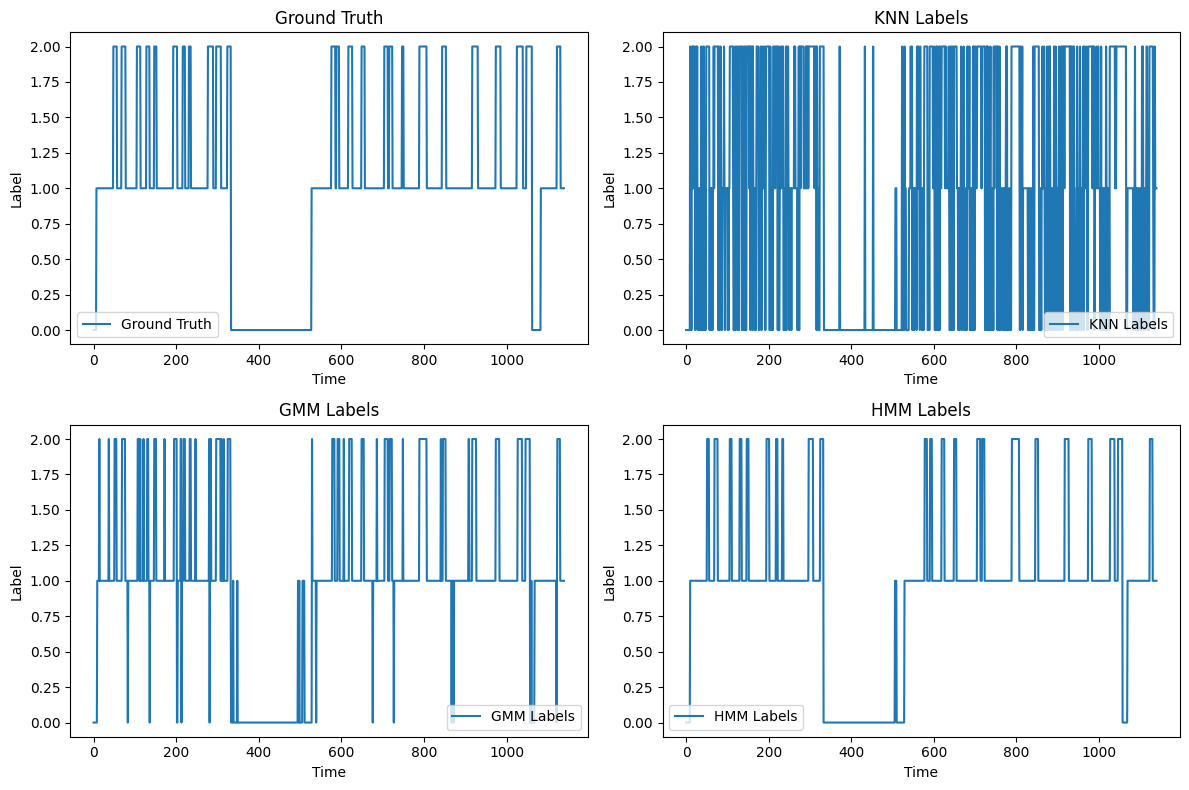

In [91]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.plot(groundTruthLabels, label='Ground Truth')
plt.title('Ground Truth')
plt.xlabel('Time')
plt.ylabel('Label')
plt.legend()

plt.subplot(222) ### I know for this random seed that I need to arange the labels as such in order for it to be same as other plots
rearrangedKNNlabels = np.zeros_like(labels_knn)
rearrangedKNNlabels[labels_knn == 2] = 0
rearrangedKNNlabels[labels_knn == 1] = 1
rearrangedKNNlabels[labels_knn == 0] = 2
print("KNNaccuracy: ", np.sum(rearrangedKNNlabels == groundTruthLabels)/groundTruthLabels.size)

plt.plot( rearrangedKNNlabels, label='KNN Labels')
plt.title('KNN Labels')
plt.xlabel('Time')
plt.ylabel('Label')
plt.legend()

print("GMMaccuracy: ", np.sum(labels_gmm == groundTruthLabels)/groundTruthLabels.size)

plt.subplot(223)
plt.plot( labels_gmm, label='GMM Labels')
plt.title('GMM Labels')
plt.xlabel('Time')
plt.ylabel('Label')
plt.legend()

print("HMMaccuracy: ", np.sum(labels_hmm == groundTruthLabels)/groundTruthLabels.size)

plt.subplot(224)
plt.plot( labels_hmm, label='HMM Labels')
plt.title('HMM Labels')
plt.xlabel('Time')
plt.ylabel('Label')
plt.legend()

plt.tight_layout()
plt.show()

### EXPLANATION  

KNN: This performs the worst as we are constrained to euclidian distance as our only metric of seperation. Does not account for different variances on different features. We also don't consider the samples as related in time.  

GMM: Performs significantly better than KNN as we allow different variances/covariances for/between our different features when clustering. We have the added benefits of learning gaussian distributions to describe each of our classes. We still don't consider the samples as related in time. 

HMM: Performs the best as we get all the benefits of a GMM while now considering transition probabilities between states. In qualitative terms, we now consider the fact the audio is not likely to quickly switch between music/laughter/speech and that if one of these is occuring the most likely state for the next column of our spectrogram is that it will continue. Even though the percentage correct is only 2-3% greater than GMMs, the labels make much more sense due to these considerations. 